# Tester for probabilistic Regression

## DGP

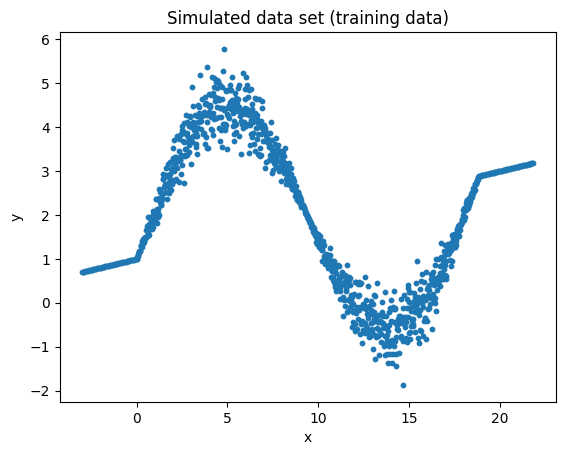

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def dgp_1(n):
    np.random.seed(42)
    N = 1000 # number of data points
    x_train = np.random.uniform(-10, 10, (N, 1)).astype(np.float32)
    y_train = (2 * x_train + np.random.normal(0, np.abs(x_train) + 1, (N, 1))).astype(np.float32)
    return x_train.reshape(1,-1), y_train.reshape(1,-1)


def dgp_2(n):
    np.random.seed(32)
    x = np.linspace(0,1*2*np.pi,n)
    y1 = 3*np.sin(x)
    y1 = np.concatenate((np.zeros(60), y1+np.random.normal(0,0.15*np.abs(y1),n),np.zeros(60)))
    x=np.concatenate((np.linspace(-3,0,60),np.linspace(0,3*2*np.pi,n),np.linspace(3*2*np.pi,3*2*np.pi+3,60)))
    y2 = 0.1*x+1
    y=y1+y2
    return x.reshape(-1,1),y.reshape(-1,1)

dgp = dgp_2

x_train, y_train = dgp(1000)
plt.scatter(x_train, y_train, s=10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Simulated data set (training data)')

# Predict the distribution
x_test = np.linspace(-10, 30, 100).reshape(-1, 1)

In [3]:
#%pip install tabpfn

In [3]:
import os
# Set Keras backend to PyTorch
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1" #Needed on MAC to avoid MPS error (22 Nov 2024)
os.environ["KERAS_BACKEND"] = "torch" # Before importing Keras!

import numpy as np
from keras import layers, Input, Model
from keras.optimizers import Adam
import torch
from torch.distributions import Normal
import matplotlib.pyplot as plt
import time


# Print versions
import keras
print(f"Keras version: {keras.__version__}")
print(f"Backend: {keras.backend.backend()}")
print(f"torch version: {torch.__version__}")

# Print Information on GPU
# Check GPU availability
if torch.cuda.is_available():
  print(f"GPU is available: {torch.cuda.get_device_name(0)}")
else:
  print("GPU is not available.")


Keras version: 3.12.0
Backend: torch
torch version: 2.9.1
GPU is not available.


## Probabilistic Regression using NN

In [4]:
# Wrapper function to convert model output to a PyTorch Normal distribution
#@staticmethod
def output_to_gaussian_distribution(output):
    mean = output[:, :1]
    log_variance = output[:, 1:]
    scale = torch.exp(log_variance)  # Ensure positive scale
    return Normal(loc=mean, scale=scale)

In [5]:
# Define the model
inputs = Input(shape=(1,))
x = layers.Dense(20, activation="tanh")(inputs)
x = layers.Dense(50, activation='tanh')(x)
x = layers.Dense(20, activation='tanh')(x)
outputs = layers.Dense(2)(x)  # Outputs mean and log(variance)
model = Model(inputs=inputs, outputs=outputs)

# Custom Negative Log-Likelihood Loss
def negative_log_likelihood(y_true, output):
    dist = output_to_gaussian_distribution(output)
    return -dist.log_prob(torch.tensor(y_true)).mean()

# Compile the model
model.compile(optimizer="adam", loss=negative_log_likelihood)

print(F'Prediction on untrained model (5 Datapoints)\n {model.predict(x_train[0:5])}')

# Train the model and measure timing
start_time = time.time()
model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)
torch_training_time = time.time() - start_time

print(f"Torch Training Time: {torch_training_time:.2f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
Prediction on untrained model (5 Datapoints)
 [[ 0.32897863 -0.12779582]
 [ 0.3278386  -0.12804306]
 [ 0.32664686 -0.1282601 ]
 [ 0.3254005  -0.12844464]
 [ 0.32409677 -0.12859425]]


/var/folders/bk/0vv7sh9n43n3dm4fth1qw93r0000gq/T/ipykernel_52734/2257829949.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -dist.log_prob(torch.tensor(y_true)).mean()


Torch Training Time: 27.75 seconds


In [6]:
dist = output_to_gaussian_distribution(model(x_test))

# Use the distribution
samples = dist.sample((5,))  # Draw 5 samples
print("Torch Samples:", samples.shape)

log_p = dist.log_prob(torch.tensor(0.1)).cpu().detach().numpy()
log_p.shape

Torch Samples: torch.Size([5, 100, 1])


(100, 1)

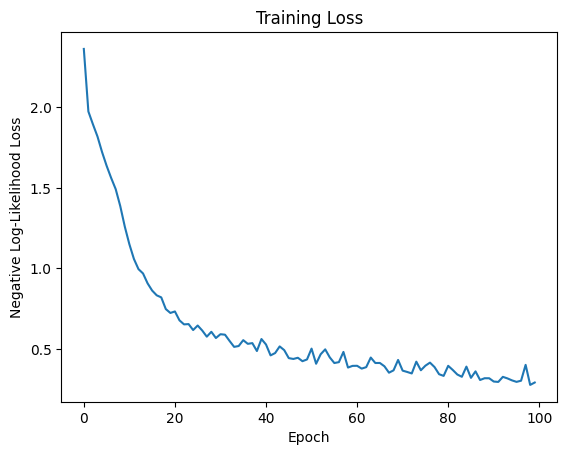

In [7]:
### Plotting the loss curve
plt.plot(model.history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("Negative Log-Likelihood Loss")
plt.title("Training Loss")
plt.show()

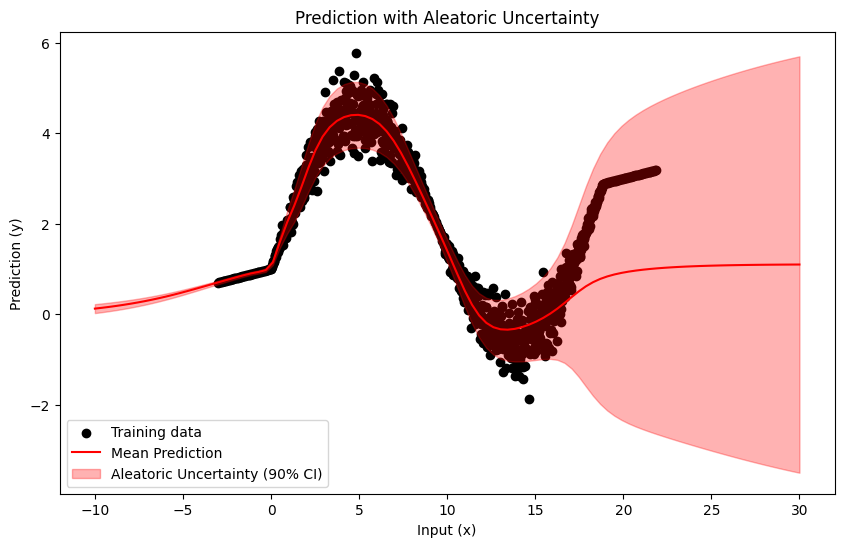

In [8]:
# Berechne Quantile direkt aus der Verteilung
# Compute 5% and 95% quantiles directly
quantile_5 = dist.icdf(torch.tensor(0.05)).cpu().detach().numpy()
quantile_95 = dist.icdf(torch.tensor(0.95)).cpu().detach().numpy()
mean = dist.mean.cpu().detach().numpy().squeeze()
# Visualisierung
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(x_train, y_train, color="black", label="Training data")
plt.plot(x_test, mean, color="red", label="Mean Prediction")
plt.fill_between(
    x_test.ravel(),
    quantile_5.squeeze(),  # 5%-Quantil
    quantile_95.squeeze(),  # 95%-Quantil
    color="red",
    alpha=0.3,
    label="Aleatoric Uncertainty (90% CI)"
)
plt.legend()
plt.xlabel("Input (x)")
plt.ylabel("Prediction (y)")
plt.title("Prediction with Aleatoric Uncertainty")
plt.show()